In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
from skimage.morphology import label
from scipy.ndimage import measurements
import sys
import numba as nb

In [2]:
# Interesting puzzle. The tempting first choice is to set the rotation 
# around the centre point and have a max fill of 6 cells for
# each region which doesn't give any solution (the long group bottom
# right I guess). Offsetting and padding give options as do reducing 
# the number of cells filled per group.I've looped through the options
# below but none of the other options gave a valid solution before I 
# got to the published solution. I played around a bit more and
# don't think any more padding would improve but haven't proved it

url='https://www.janestreet.com/puzzles/spiral-region/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:15]))

Shade some cells in the grid below such that the set of shaded cells is connected, has 90-degree rotational symmetry about its center, and contains the same number of shaded cells in each outlined region. The answer to this puzzle is the smallest possible product of the areas of the connected groups of empty squares in the completed grid. — (Note: This post has been edited 2018-09-04 to change the answer to the smallest possible product of areas of connected groups of empty squares.)


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/09/20180904_spiral_region.png" width="250" >

In [3]:
# set up the groups
groups = np.array([[19, 19, 19,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  4],
                   [19, 19,  5,  1,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4],
                   [19,  5,  5,  1,  6,  6,  6,  2,  2,  7,  7,  3,  3,  4],
                   [ 5,  5,  5,  9,  6, 10,  6,  6,  2,  7,  8,  8,  4,  4],
                   [ 9,  5,  9,  9, 10, 10, 10, 11,  2,  7,  8,  8,  8,  2],
                   [ 9,  5,  9, 10, 10, 12, 10, 11,  2,  7,  7,  7,  8,  2],
                   [ 9,  9,  9,  9, 12, 12, 11, 11,  2, 13,  8,  8,  8,  2],
                   [14,  9,  9, 12, 12, 11, 11,  2,  2, 13,  2,  2,  2,  2],
                   [14, 14, 12, 12,  2,  2,  2,  2, 13, 13, 13, 15, 15,  2],
                   [14, 16, 16, 17,  2, 18, 18, 18, 18, 13, 13, 13, 15,  2],
                   [14, 14, 16, 17,  2,  2, 18,  0, 18, 20, 20, 15, 15,  2],
                   [16, 16, 16, 17, 17,  2,  2,  0,  0,  0, 20, 20, 15,  2],
                   [16, 17, 16, 17, 17, 17,  2,  2,  0,  0, 20, 20, 15,  2],
                   [16, 17, 17, 17, 17, 17, 17,  2,  2,  2,  2,  2,  2,  2]]
                  ,dtype=int)

In [4]:
class Matrix():
    def __init__(self,groups,max_cells,offset):
        self.groups = groups
        self.max_cells = max_cells
        self.fixed =  np.ones((7,7),dtype=int)*-1 
        self.offset = offset
        self.solution = []
        self.end_flag = 0
        
    # solve by backtracking only considering the 7x7 grid 
    # which gets rotated
    def solve(self):
        if self.end_flag == 0:
            for row in range(7):
                for col in range(7):
                    if self.fixed[row,col] == -1:
                        for digit in range(2):
                            if self.possible(digit,row,col):
                                self.fixed[row,col] = digit
                                self.solve()
                                self.fixed[row,col] = -1
                        return
                    
            big = self.get_big(self.fixed)
            self.solution.append(dcopy(big))

    def possible(self,digit,row,col):
        x = copy(self.fixed)
        x[row,col] == digit
        big =self.get_big(x)
 
        #check connectivity
        if np.max(label(big[:-1,:-1]!=0,connectivity=1)) > 1:
            return False
            
        # check the number counts as determined above are not
        # breached
        if not self.test_totals(big,self.groups,self.max_cells):
            return False

        return True
   
    @staticmethod
    @nb.njit
    #test the count per cell is not breached
    def test_totals(x,groups,max_cells):
        for group in range(21):                         
            if np.sum(np.ravel(x)[np.ravel(groups)==group]>0) > max_cells:
                  return False 
            if np.sum(np.ravel(x)[np.ravel(groups)==group] != 0) < max_cells :
                  return False     
        return True
    
    #code to turn the 7x7 grid into a 14x14 grid with rotational
    #symmetry. Can make a smaller grid and then pad.
    def get_big(self,x):
        x1 = dcopy(x)
        x2 = dcopy(x)
        x3 = dcopy(x)
        if self.offset == 0:
            x1 = np.rot90(x1 ,1)
            x2 = np.rot90(x2 ,2) 
            x3 = np.rot90(x3, 3)
            y = np.block([[x,x3],[x1,x2]])
        
        if self.offset == 1:
            x1 = np.rot90(x1[:,:-1] ,1)
            x2 = np.rot90(x2[:-1,:-1] ,2) 
            x3 = np.rot90(x3[:-1,:], 3)   
            y = np.block([[x,x3],[x1,x2]])
            y = np.pad(y,((0,1),(0,1)),'constant',constant_values=0)
        
        if self.offset == 2:
            x1 = np.rot90(x1[:,:-1] ,1)
            x2 = np.rot90(x2[:-1,:-1] ,2) 
            x3 = np.rot90(x3[:-1,:], 3)   
            y = np.block([[x,x3],[x1,x2]])
            y = np.pad(y,((1,0),(0,1)),'constant',constant_values=0)
        
        if self.offset == 3:
            x1 = np.rot90(x1[:,:-1] ,1)
            x2 = np.rot90(x2[:-1,:-1] ,2) 
            x3 = np.rot90(x3[:-1,:], 3)   
            y = np.block([[x,x3],[x1,x2]])
            y = np.pad(y,((0,1),(1,0)),'constant',constant_values=0)
            
        if self.offset == 4:
            x1 = np.rot90(x1[:,:-1] ,1)
            x2 = np.rot90(x2[:-1,:-1] ,2) 
            x3 = np.rot90(x3[:-1,:], 3)   
            y = np.block([[x,x3],[x1,x2]])
            y = np.pad(y,((1,0),(1,0)),'constant',constant_values=0)

        return y
   
    # work out the area for the solution
    def areas(self,grid):
        labels, num = measurements.label(grid==0)
        areas = measurements.sum(grid==0, labels, index=range(1, num+1))
        return np.prod(areas)
  
    # print out the solution
    def print_best(self):
        if len(self.solution) == 0:
            print("No solutions")
        else:
            area =np.zeros(len(self.solution))
            for i in range(len(self.solution)):
                area[i] = self.areas(self.solution[i])
            best = self.solution[np.argmin(area)]
            print("\n***SOLVED***")
            print("Area for solution is :{:,.0f}\n".format(np.min(area)))
            self.grid_print(groups,best)

    # function to print the solution
    def grid_print(self,groups,numbers):
        fig,ax = plt.subplots(1,2,figsize=(8,4))
        x = np.array((numbers).astype('int').astype('str'))
        x[x=="0"] =""
        x[x=="1"] ="+"
        ax1 = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20b",fmt="",linewidths=1,ax=ax[0])
        ax1.axis("off")
        ax2 = sns.heatmap(numbers,cbar=False,cmap="Greys",center=2,fmt="",linewidths=1,ax=ax[1],linecolor="grey")
        ax2.axis("off")
        plt.tight_layout()
   
        

Per range number of cells :5, Offset:1

***SOLVED***
Area for solution is :1,203,200

Solution took 3.0692 seconds


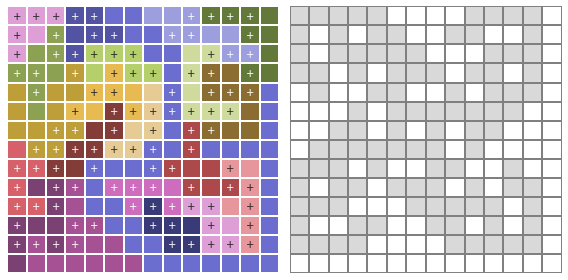

In [5]:
# Looking at the puzzle have options
# none of the other offsets or max fills work
# so have just displayed the solution

overall_start = time.perf_counter()

for offset,max_fill in itertools.product(range(1,2),range(5,6)):
    
    start = time.perf_counter()
    print("Per range number of cells :{}, Offset:{}".format(max_fill,offset))
    test = Matrix(groups,max_fill,offset)
    test.solve()
    stop =  time.perf_counter()
    test.print_best()
    print('Solution took {:0.4f} seconds'.format((stop-start)))

#rint('\nAll options took {:0.4f} seconds'.format((stop-overall_start)))


In [6]:
url='https://www.janestreet.com/puzzles/solutions/september-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The smallest product we were able to find is 1203200 , which results from the shading shown on the left. Congrats to those of you who found it!


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/10/20181001_spiral_ans.png" width="300" >

In [7]:
solution= np.array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
                    [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
                    [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
                    [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
                    [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0],
                    [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                    [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0],
                    [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
                    [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0],
                    [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0],
                    [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
                    [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0],
                    [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],dtype =int)